# Simple Neural Network Exercise

## Assignment

In this assignment, you will create a simple network using dense layers. You will also create 2 more versions of it where you adjust the number of layers and neurons per layer to see if you can achieve better performance.

Data Source: Kaggle Heart Disease Dataset: https://www.kaggle.com/fedesoriano/heart-failure-prediction

Direct link to data: heart.csv: https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv

## Data Dictionary

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

## Task

Use a neural network to predict heart disease using the given data.

Make sure you:

1. Explore and clean the data if needed.
2. Perform a train-test split on your data.
3. Use a column transformer to scale the numeric features and one-hot encode the categorical features.
4. Define your base sequential model.
5. Include the number of features of each sample in your input layer.
6. Use the correct activation function and the correct number of neurons for your output layer.
7. Compile your model with the correct loss function and an optimizer (‘adam’ is a fine choice).
8. Plot your model’s training history.
9. Evaluate your models with appropriate metrics.

After you’ve created, fit, and evaluated your first model, try 2 more versions of it with different numbers of layers and neurons to see if you can create a model that scores better on the testing data.

# Preliminary Steps

In [270]:
# import libraries

# general
import pandas as pd

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# visualization
import matplotlib.pyplot as plt

# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [271]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv')

In [272]:
# inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# 1. Explore and clean the data as needed.

In [273]:
# drop any duplicates
df.drop_duplicates(inplace = True)

# check
df.duplicated().sum()

0

In [274]:
# check for any missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [275]:
# check dtypes and inconsistent/impossible values against data dictionary
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [276]:
cat_cols = list(df.select_dtypes(include='object'))

for col in cat_cols:
    print(col)
    print(df[col].value_counts(dropna = False))
    print()

Sex
M    725
F    193
Name: Sex, dtype: int64

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

RestingECG
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

ExerciseAngina
N    547
Y    371
Name: ExerciseAngina, dtype: int64

ST_Slope
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64



In [277]:
num_cols = list(df.select_dtypes(include = 'number'))

df[num_cols].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [278]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [279]:
# i assume that a RestingBP of 0 is a mistake and will drop this row
df = df[df['RestingBP'] != 0]

# check
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [280]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [281]:
# since there are 172 instances of cholesterol 0, i will assume this is
# possible and keep these rows

# 2. Perform a train-test split on your data.

In [282]:
# X y split
target = 'HeartDisease'
y = df[target]
X = df.drop(columns = target)

# check
print(f"y:\n{y}")
print(f"X:\n{X}")

y:
0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 917, dtype: int64
X:
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M 

In [283]:
# binary encode and passthrough: 'Sex', 'ExerciseAngina'

# Sex
X['Sex'].replace({'F': 1, 'M': 0}, inplace = True)
X.rename({'Sex': 'Female'}, inplace = True)

# ExerciseAngina
X['ExerciseAngina'].replace({'Y': 1, 'N': 0}, inplace = True)

# check
print(X['Sex'].value_counts())
print(X['ExerciseAngina'].value_counts())

0    724
1    193
Name: Sex, dtype: int64
0    546
1    371
Name: ExerciseAngina, dtype: int64


In [284]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# check
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (687, 11)
X_test shape: (230, 11)
y_train shape: (687,)
y_test shape: (230,)


# 3. Use a column transformer to scale the numeric features and one-hot encode the categorical features.

In [285]:
# scale: 'Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'

scale_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

scaler = StandardScaler()

scale_tuple = (scaler, scale_cols)

In [286]:
# ohe: 'ChestPainType', 'RestingECG', 'ST_Slope'

ohe_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']

ohe = OneHotEncoder(handle_unknown = 'ignore')

ohe_tuple = (ohe, ohe_cols)

In [287]:
# already scaled (passthrough): 'FastingBS'

In [288]:
# make preprocessor (column transformer)

preprocessor = make_column_transformer(scale_tuple,
                                      ohe_tuple,
                                      remainder = 'passthrough')

# check
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR',
                                  'Oldpeak']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ChestPainType', 'RestingECG', 'ST_Slope'])])

In [289]:
# fit and transform X_train and X_test
X_train = preprocessor.fit_transform(X_train)

# check
X_train

array([[ 0.24734343,  1.27485964,  1.29373674, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.24734343,  1.27485964, -1.8711525 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56635144,  0.9908317 ,  0.09070867, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.20436747, -1.28139187,  0.4238549 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67268745,  1.10444288, -1.8711525 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.45403264,  0.9908317 ,  1.75643984, ...,  1.        ,
         0.        ,  0.        ]])

In [290]:
# fit and transform X_train and X_test
X_test = preprocessor.transform(X_test)

# check
X_test

array([[-0.92235262, -0.14528009,  0.29429803, ...,  1.        ,
         0.        ,  0.        ],
       [-0.07166459,  0.70680375,  2.92245167, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.20436747,  1.55888759, -1.8711525 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.07166459, -0.42930803, -1.8711525 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.03467142, -1.28139187,  0.05369242, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56036865,  0.30916463,  0.16474116, ...,  1.        ,
         0.        ,  0.        ]])

# 4. Define your base sequential model.

In [291]:
# define sequential model
model = Sequential()

# 5. Include the number of features of each sample in your input layer.

In [292]:
# define network structure (how many features are in X)
input_features = X_train.shape[1]

# check
input_features

18

In [293]:
# first hidden layer (with info on input layer)
model.add(Dense(input_features, # how many neurons in layer*
                input_dim = input_features, # number of features in X
                activation = 'relu' # common to use in hidden layers
               ))

# * good choice to start with number of features in X

# 6. Use the correct activation function and the correct number of neurons for your output layer.

In [294]:
# output layer
model.add(Dense(1, # number of nodes in output
                activation = 'sigmoid' # for binary classification
               ))

# 7. Compile your model with the correct loss function and an optimizer (‘adam’ is a fine choice).

In [295]:
# compile
model.compile(loss = 'bce', # for binary classification
              optimizer = 'adam' # common
             )

In [296]:
# fit
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 10
                   )

Epoch 1/10
22/22 [==============================] - 1s 8ms/step - loss: 0.7231 - val_loss: 0.6934
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 0.6543 - val_loss: 0.6285
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 0.6012 - val_loss: 0.5808
Epoch 4/10
22/22 [==============================] - 0s 2ms/step - loss: 0.5597 - val_loss: 0.5388
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 0.5230 - val_loss: 0.5056
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 0.4923 - val_loss: 0.4787
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 0.4651 - val_loss: 0.4566
Epoch 8/10
22/22 [==============================] - 0s 2ms/step - loss: 0.4435 - val_loss: 0.4346
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 0.4241 - val_loss: 0.4197
Epoch 10/10
22/22 [==============================] - 0s 2ms/step - loss: 0.4077 - val_loss: 0.4086


# 8. Plot your model's training history.

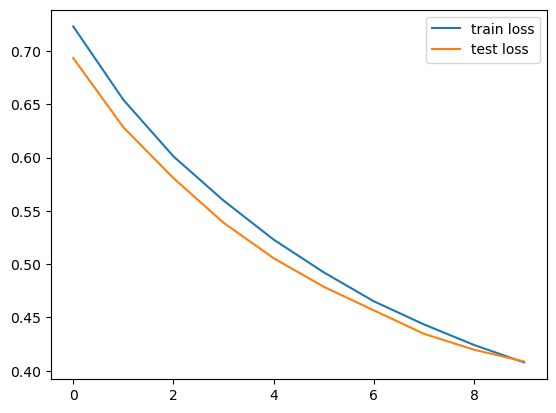

In [297]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.legend();

# 9. Evaluate your models with appropriate metrics.

8/8 [==============================] - 0s 855us/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        90
           1       0.89      0.84      0.86       140

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.84      0.83      0.84       230



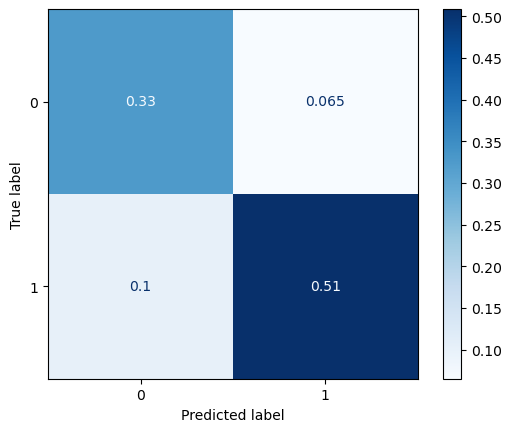

In [301]:
# create test predictions
test_pred = model.predict(X_test)

# convert to binary (make threshold 0.5)
test_pred_boolean = test_pred >= 0.5
test_pred_binary = test_pred_boolean.astype(int)

# evaluate model
print(classification_report(y_test, 
                            test_pred_binary))
ConfusionMatrixDisplay.from_predictions(y_test,
                                       test_pred_binary,
                                       normalize = 'all',
                                       cmap = 'Blues');

# 10. Try 2 more versions of the model with different numbers of layers and neurons.

In [303]:
# model version 2
model2 = Sequential()

In [304]:
# first hidden layer (with info on input layer)
model2.add(Dense(input_features, # how many neurons in layer*
                input_dim = input_features, # number of features in X
                activation = 'relu' # common to use in hidden layers
               ))

# * good choice to start with number of features in X

# second hidden layer
model2.add(Dense(input_features - (input_features * 0.75),
                activation = 'relu'
               ))

# third hidden layer
model2.add(Dense(input_features - (input_features * 0.5),
                activation = 'relu'
               ))

# fourth hidden layer
model2.add(Dense(input_features - (input_features * 0.25),
                activation = 'relu'
               ))

In [305]:
# output layer
model2.add(Dense(1, # number of nodes in output
                activation = 'sigmoid' # for binary classification
               ))

In [306]:
# compile
model2.compile(loss = 'bce', # for binary classification
              optimizer = 'adam' # common
             )

In [308]:
# fit
history2 = model2.fit(X_train, 
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 10
                   )

Epoch 1/10
22/22 [==============================] - 0s 4ms/step - loss: 0.4207 - val_loss: 0.3838
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 0.4035 - val_loss: 0.3684
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3863 - val_loss: 0.3635
Epoch 4/10
22/22 [==============================] - 0s 3ms/step - loss: 0.3702 - val_loss: 0.3529
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3547 - val_loss: 0.3428
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3376 - val_loss: 0.3326
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3245 - val_loss: 0.3322
Epoch 8/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3140 - val_loss: 0.3263
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3078 - val_loss: 0.3272
Epoch 10/10
22/22 [==============================] - 0s 2ms/step - loss: 0.3024 - val_loss: 0.3192


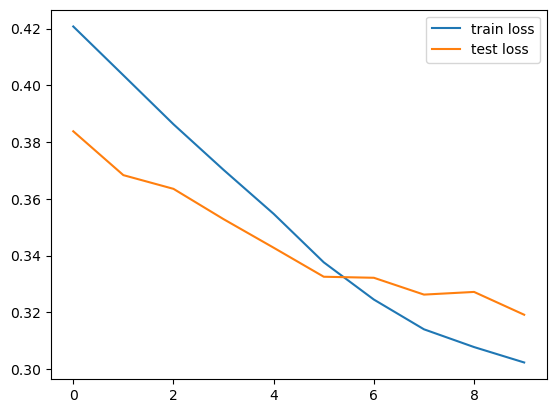

In [310]:
plt.plot(history2.history['loss'], label = 'train loss')
plt.plot(history2.history['val_loss'], label = 'test loss')
plt.legend();

8/8 [==============================] - 0s 997us/step
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        90
           1       0.91      0.89      0.90       140

    accuracy                           0.88       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.88      0.88      0.88       230



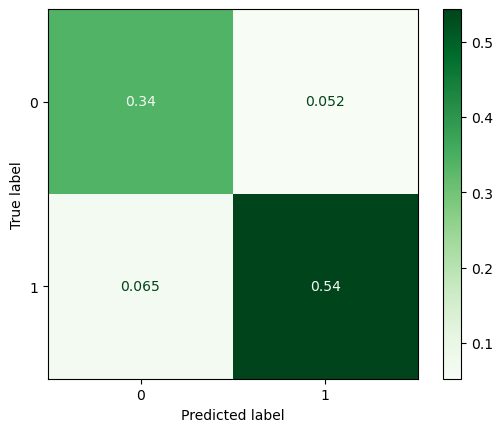

In [311]:
# create test predictions
test_pred2 = model2.predict(X_test)

# convert to binary (make threshold 0.5)
test_pred2_boolean = test_pred2 >= 0.5
test_pred2_binary = test_pred2_boolean.astype(int)

# evaluate model
print(classification_report(y_test, 
                            test_pred2_binary))
ConfusionMatrixDisplay.from_predictions(y_test,
                                       test_pred2_binary,
                                       normalize = 'all',
                                       cmap = 'Greens');

In [312]:
# model version 3
model3 = Sequential()

In [313]:
# first hidden layer (with info on input layer)
model3.add(Dense(input_features, # how many neurons in layer*
                input_dim = input_features, # number of features in X
                activation = 'relu' # common to use in hidden layers
               ))

# * good choice to start with number of features in X

# second hidden layer
model3.add(Dense(input_features - (input_features * 0.9),
                activation = 'relu'
               ))

# third hidden layer
model3.add(Dense(input_features - (input_features * 0.8),
                activation = 'relu'
               ))

# fourth hidden layer
model3.add(Dense(input_features - (input_features * 0.7),
                activation = 'relu'
               ))

# fifth hidden layer
model3.add(Dense(input_features - (input_features * 0.6),
                activation = 'relu'
               ))

# sixth hidden layer
model3.add(Dense(input_features - (input_features * 0.5),
                activation = 'relu'
               ))

# seventh hidden layer
model3.add(Dense(input_features - (input_features * 0.4),
                activation = 'relu'
               ))

# eighth hidden layer
model3.add(Dense(input_features - (input_features * 0.3),
                activation = 'relu'
               ))

# ninth hidden layer
model3.add(Dense(input_features - (input_features * 0.2),
                activation = 'relu'
               ))

# tenth hidden layer
model3.add(Dense(input_features - (input_features * 0.1),
                activation = 'relu'
               ))

In [314]:
# output layer
model3.add(Dense(1, # number of nodes in output
                activation = 'sigmoid' # for binary classification
               ))

In [315]:
# compile
model3.compile(loss = 'bce', # for binary classification
              optimizer = 'adam' # common
             )

In [316]:
# fit
history3 = model3.fit(X_train, 
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 10
                   )

Epoch 1/10
22/22 [==============================] - 1s 12ms/step - loss: 0.6759 - val_loss: 0.6633
Epoch 2/10
22/22 [==============================] - 0s 3ms/step - loss: 0.6163 - val_loss: 0.6196
Epoch 3/10
22/22 [==============================] - 0s 3ms/step - loss: 0.5594 - val_loss: 0.5819
Epoch 4/10
22/22 [==============================] - 0s 3ms/step - loss: 0.5222 - val_loss: 0.5518
Epoch 5/10
22/22 [==============================] - 0s 3ms/step - loss: 0.4849 - val_loss: 0.4946
Epoch 6/10
22/22 [==============================] - 0s 3ms/step - loss: 0.4383 - val_loss: 0.4451
Epoch 7/10
22/22 [==============================] - 0s 3ms/step - loss: 0.3974 - val_loss: 0.4136
Epoch 8/10
22/22 [==============================] - 0s 3ms/step - loss: 0.3796 - val_loss: 0.3836
Epoch 9/10
22/22 [==============================] - 0s 3ms/step - loss: 0.3666 - val_loss: 0.3968
Epoch 10/10
22/22 [==============================] - 0s 3ms/step - loss: 0.3591 - val_loss: 0.3809


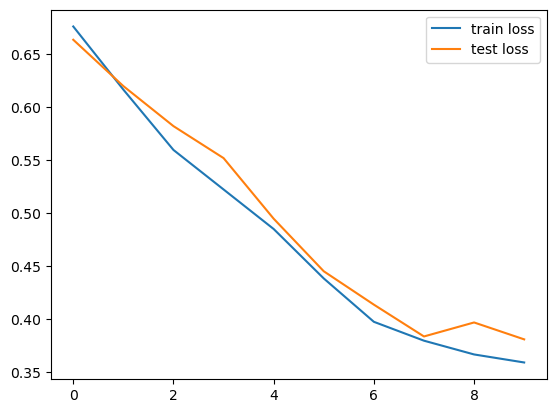

In [317]:
plt.plot(history3.history['loss'], label = 'train loss')
plt.plot(history3.history['val_loss'], label = 'test loss')
plt.legend();

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        90
           1       0.88      0.91      0.90       140

    accuracy                           0.87       230
   macro avg       0.87      0.86      0.87       230
weighted avg       0.87      0.87      0.87       230



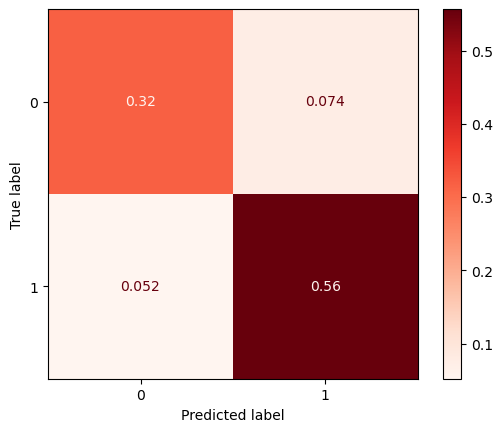

In [318]:
# create test predictions
test_pred3 = model3.predict(X_test)

# convert to binary (make threshold 0.5)
test_pred3_boolean = test_pred3 >= 0.5
test_pred3_binary = test_pred3_boolean.astype(int)

# evaluate model
print(classification_report(y_test, 
                            test_pred3_binary))
ConfusionMatrixDisplay.from_predictions(y_test,
                                       test_pred3_binary,
                                       normalize = 'all',
                                       cmap = 'Reds');